# Blind source separation (BSS) of maternal and fetal ECG using ICA

Before you start working, please install the wfdb package. Open anaconda prompt, activate bm-336546 and type `pip install wfdb`. Do not try to install the package through the notebook. Only if you work on GoogleColab, uncomment the following cell and run it:

In [1]:
# !pip install wfdb

BSS is a common real-life problem. In many cases, when we measure signals, we use multiple sensors of the same type and the signals recieved at the different sensors are quite similar and not well intepretable. The signals recieved are actually a mixture of independent sources. The task is to seperate these sources from the recieved signals by some kind of reverse engineering. In our task, there are three ECG electrodes that actually recieve a mixture of the maternal ECG, the fetal ECG and noise. The way to separate those sources will be by independent component analysis (ICA). In general, ICA tries to look for a new axes system where all of the axes are statistically independent.  

In [2]:
import pickle
import wfdb
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

When a pregnant woman needs to have an ECG recording, the doctor places several leads on her belly. The signals recorded in each lead do not look like ECG because of two reasons: First, the location is not so close to the heart as it should be and secondly, every lead records a mixture of three signals which are the maternal ECG, the fetal ECG and noise. ICA can help us to reconstruct the signals from the leads. Let us start with showing the different leads (3 in total) which are basically the mixed signals. Every signal in the following figure are the "ECG" signals measured in different ECG leads.

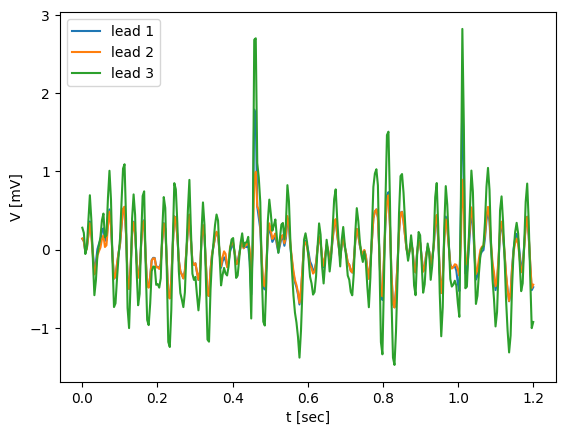

(3, 300)


In [3]:
X = np.load('mixed_signals.npy')
Fs = 250 # [Hz]
t = np.linspace(0, X.shape[1]/Fs, X.shape[1])
plt.plot(t, X.T)
plt.xlabel('t [sec]')
plt.ylabel('V [mV]')
plt.legend(['lead 1','lead 2','lead 3'])
plt.show()
print(X.shape)

We treat every lead as a feature and every time sample within a lead as a sample.
As we can see, all the leads recorded pretty similar signals which none of them looks like an ECG. That's because every lead recorded a mixture of the maternal ECG, fetal ECG and noise as mentioned. We assume that the mixture is linear. Thus, the recieved signals above $\left(X \in R^{3X300}\right)$ can be written as $X=AS$ where $S\in R^{3X300}$ represents the source signals (one row vector is the maternal ECG, another is the fetal ECG and the noise is the remaining one). $A$ represents the linear mixture which is unknown to us. Our goal is to recover the sources, meaning find out what were the original maternal and fetal ECGs. ICA, basically tries to estimate the "demixing matrix", $W=A^{-1}$. Since, if we had this $W$, all we had to do is take the given data $X$ and simply calculate $S=WX$. We will try to estimate $W$ and then we can directly estimate the sources. We should notice that what we really calculate is $S=WX_{whiten}$. We will see that later on.

The number of independent components is the number of unknown sources. We are looking for two sources and the noise will be the third one. In our specific case, the number of sources is the number of features (3). In general, the number of features (different leads, different sensors of the same type) should be equal to the number of sources or larger in order to recover the sources.

For efficient calculations, we first whiten the data. Whitening is the process of decorrelating the features and force the variance of every feature to be 1. Let's see how it is done mathematically:

$X_{whiten}=\Lambda^{-1/2}U^T(X-\mu_x)$ where $U$'s columns are the eigen vectors of the covariance of the centered $X$, which is $(X-\mu_x)(X-\mu_x)^T$. $\Lambda$ is a diagonal matrix containing the adequate eigen values, meaning the first eigen value matches the first column in $U$ etc. Knowing that, can you explain how is the whitening process relative to a machine learning algorithm that we already saw and mention what is the ML algorithm? Think about the mean and covarince of $X_{whiten}$. Explain how does it couple with the other machine learning algorithm that you mentioned above. Write your answer in the following cell.

*Note: In diagonal matrices, the notation of $\Lambda^{-1/2}$ means the square root of the $\Lambda^{-1}$ elements. This also implies that $\Lambda^{-1/2}\Lambda^{-1/2}=\Lambda^{-1}$. Think what is the inverse matrix of a diagonal matrix.*

### Answer:
Whitening is a preprocess method used to transfer the data into a new basis where the features are uncorrelated and the all the variances are 1. In PCA, the axes for which the data has the most variance on are found by the eigen vectors of the covariance of the centered data. Projecting the data on those axes gives an uncorrelated data with a diagonal covariance matrix. That is exactly what is done here, only the data is also multiplied by $\Lambda^{-1/2}$ in order to normalize the variances to be equal to 1, which is a baseline assumption when using ICA (The inverse matrix of a diagonal matrix is a diagonal matrix with the inverted elements ($x^{-1}$) on the diagonal). The reason we multiply by the inverse of the square root of the variance (which is the std) is that if x has a variance of $\sigma^{2}$, $ Var(x/{\sigma}) = 1/{\sigma^{2}}*Var(x) = 1/{\sigma^{2}}*\sigma^{2} = 1 $
 Therefore, the mean of $X_{whiten}$ is 0 and the covariance is a unity matrix, whereas in PCA the projected data has a mean of 0 as well, but a covariance matrix containing the variances of the data on those axes, which are also the eigenvalues of the original centered data covariance matrix.
 In this sense, the whitening process is relative to PCA algorithm.


Here is the algorithm of the fast ICA:
1. Whiten $X$ (this part also includes centering $X$ first).
2. For each component $p$, find the value of $w^{(p)}$ which is the $p^{th}$ column vector of $W$.
3. Separate the sources using the $W$ you calculated.

Implement whitening process manually. Use `np.linalg.eigh` as part of the process.

In [4]:
def whitening(X):
    #---------------------Implement your code here:------------------------
    X_centered = X - np.mean(X,axis=1, keepdims=True)
    eps = 1e-5
    cov_x = np.cov(X_centered)
    lamda, u = np.linalg.eigh(cov_x)
    diag = np.diag(1 / np.sqrt(lamda))
    X_whiten = diag@u.T@X_centered
    #----------------------------------------------------------------------
    return X_whiten 

We will now look at the covariance matrix of the whitened data:

In [5]:
X_w = whitening(X)
print(np.cov(X_w))
X_w.shape

[[1.00000000e+00 1.66704257e-14 6.91531559e-15]
 [1.66704257e-14 1.00000000e+00 1.85358975e-15]
 [6.91531559e-15 1.85358975e-15 1.00000000e+00]]


(3, 300)

Look at the covariance matrix. Do these values match your expectations? Write your answer in the following cell.

### Answer:
As mentioned above, the covariance of the whitened data should be an identity matrix, because the decorrelating process results in zero covariances and the normalization of the variances should result in variances equal to 1. We can see that practically, we got ones on the diagonal, but all the covariances are not exactly zero (diffrence of about $10^{-17}$). The reason is that in practice the features doesn't have a uniform variance (which is an assumption) and also might contain some non-linear dependencies.

We now need to find $W \in R ^{3 x 3}$  that will allow us to reconstruct $S$ from $X_{whiten}$.

One of the most successfull algorithm is the Fixed Point ICA based on kurtosis more detailled can be find in this review (https://www.researchgate.net/publication/266589231_A_Review_of_Independent_Component_Analysis_ICA_Based_on_Kurtosis_Contrast_Function/link/551a7bb80cf2f51a6fea50ed/download)

Original paper : https://www.cs.helsinki.fi/u/ahyvarin/papers/NC97.pdf

Start with $p=0$. For each component $w^{(p)}$: 


1. Initialize $w^{(p)}$ randomly with normal distribution. For simplifying calculations, we initialized it as a random vector of the shape (3,) and not (3,1).
2. Let $w^{(p)}_n = \frac{1}{300}\sum_{i=1}^{300}[x_w^{(i)}(w^{T(p)}_{n-1}x_w^{(i)})]^3 - 3w^{(p)}_{n-1}$ 

where $x_w^{(i)}$ is $i^{th}$ column of $X_{whiten}$ and $w^{(p)}_n$ is  $w^{(p)}$ at iteration $n$.

3. $w^{(p)}_n = w^{(p)}_n- \sum_{j=0}^{p-1} (w^{T(p)}_nw^{(j)})w^{(j)}$ to decorrelate the weights. Notice that in the first case where $p=0$ then the sum will run to $p-1=-1$ which means it will not do anything and this is normal since there are no other weights so there is nothing to decorralte. If you use a for loop it should be `for j in range(p):` in order to run up to $p-1$.
4. $w^{(p)}_n = w^{(p)}_n/||w^{(p)}_n||_2$
5. If $|w^{T(p)}_nw^{(p)}_{n-1}-1| < \epsilon$ where $\epsilon=10^{-10}$ the algorithm converged for this specific p. You may store it as the $p^{th}$ column of $W$ (the 3X3 matrix that we initialized with 0) and move to the next $p$. If not, continue with the same $p$ and make another iteration, i.e. go back to step number 2 where $n=n+1$.

Implement steps (2)-(4) inclusive in `update_wp` function that takes as input arguments $w^{(p)}$ called `w_p`, the whitened data `X_w`, the current `W` and the current component $p$. It should return the updated $w^{(p)}$. This function is used in the cell that follows.

In [6]:
def update_wp(w_p,X_w,W,p):
    #---------------------Implement your code here:------------------------
    sum = 0
    for i in range(X_w.shape[1]):
        sum += np.dot(X_w[:,i], np.dot(w_p, X_w[:,i]))**3
    sum /= X_w.shape[1]
    w_p = sum -3*w_p

    for j in range(p):
        w_p -= np.dot(np.dot(w_p, W[j]), W[j])

    w_p /= np.linalg.norm(w_p)
    #----------------------------------------------------------------------
    return w_p

In [7]:
from tqdm.notebook import tqdm
np.random.seed(42)
max_iter = 3000
threshold = 1e-10
n_component = X_w.shape[0]
W = np.zeros((3,3))
for p in tqdm(range(n_component)):
    converge = False
    w_p = np.random.randn(n_component)
    iter_count = 0
    while iter_count< max_iter and not converge: 
        w_p_new = update_wp(w_p,X_w,W,p) # your function is called here
        if np.abs(w_p.dot(w_p_new) - 1) < threshold:
            converge = True
        w_p = w_p_new
        iter_count +=1
    W[p,:] = w_p

  0%|          | 0/3 [00:00<?, ?it/s]

Theoretically, $W$ should end up as an orthonormal matrix. Since our reconstruction algorithm is not perfect, you should see that $W$ is almost orthonormal matrix. Show it in the next cell. In the following cell, explain your results from the previous cell by comparing what you expected to have and your results. 

In [8]:
#---------------------Implement your code here:------------------------
maybe_eye = W@(W.T)
eye = np.eye(3)
print(maybe_eye)
np.allclose(maybe_eye,eye)
#----------------------------------------------------------------------

[[1.00000000e+00 4.98167925e-19 1.08558621e-16]
 [4.98167925e-19 1.00000000e+00 6.21654660e-16]
 [1.08558621e-16 6.21654660e-16 1.00000000e+00]]


True

### Answer:
We can see that W has ones on the diagonal and values very close to zeros elsewhere, which means it is not an identity matrix and therefore W is not orthonormal by definition, but it's very close to being one. The values outside the diagonal has a scale of about $10^{-15}$ which is practically zero.

In [9]:
# Ground true sources for comparing later on
GT = np.load('groundtruth0.npy')
GT = GT.T
maternal_ecg = GT[0,:]
fetal_ecg = GT[1,:]
noise = GT[2,:]

All we have to do now is to reconstruct the sources simply by matrix multiplication. We should note that the reconstruction is correct up to a multiplication by a constant (which can also be negative). Plot every row vector of $S$ and match it to the ground truth of maternal ECG, fetal ECG and noise. By matching, we simply mean to plot every source next to its' adequate ground true signal. You may also plot every pair at the same plot but then you should also estimate the proper constant that you should multiply your signal by. If One of your reconstructed sources needs a "flip" please mutiply by -1 even if you only plot side by side instead at the same plot. Please use the `t` for the time axis found above.

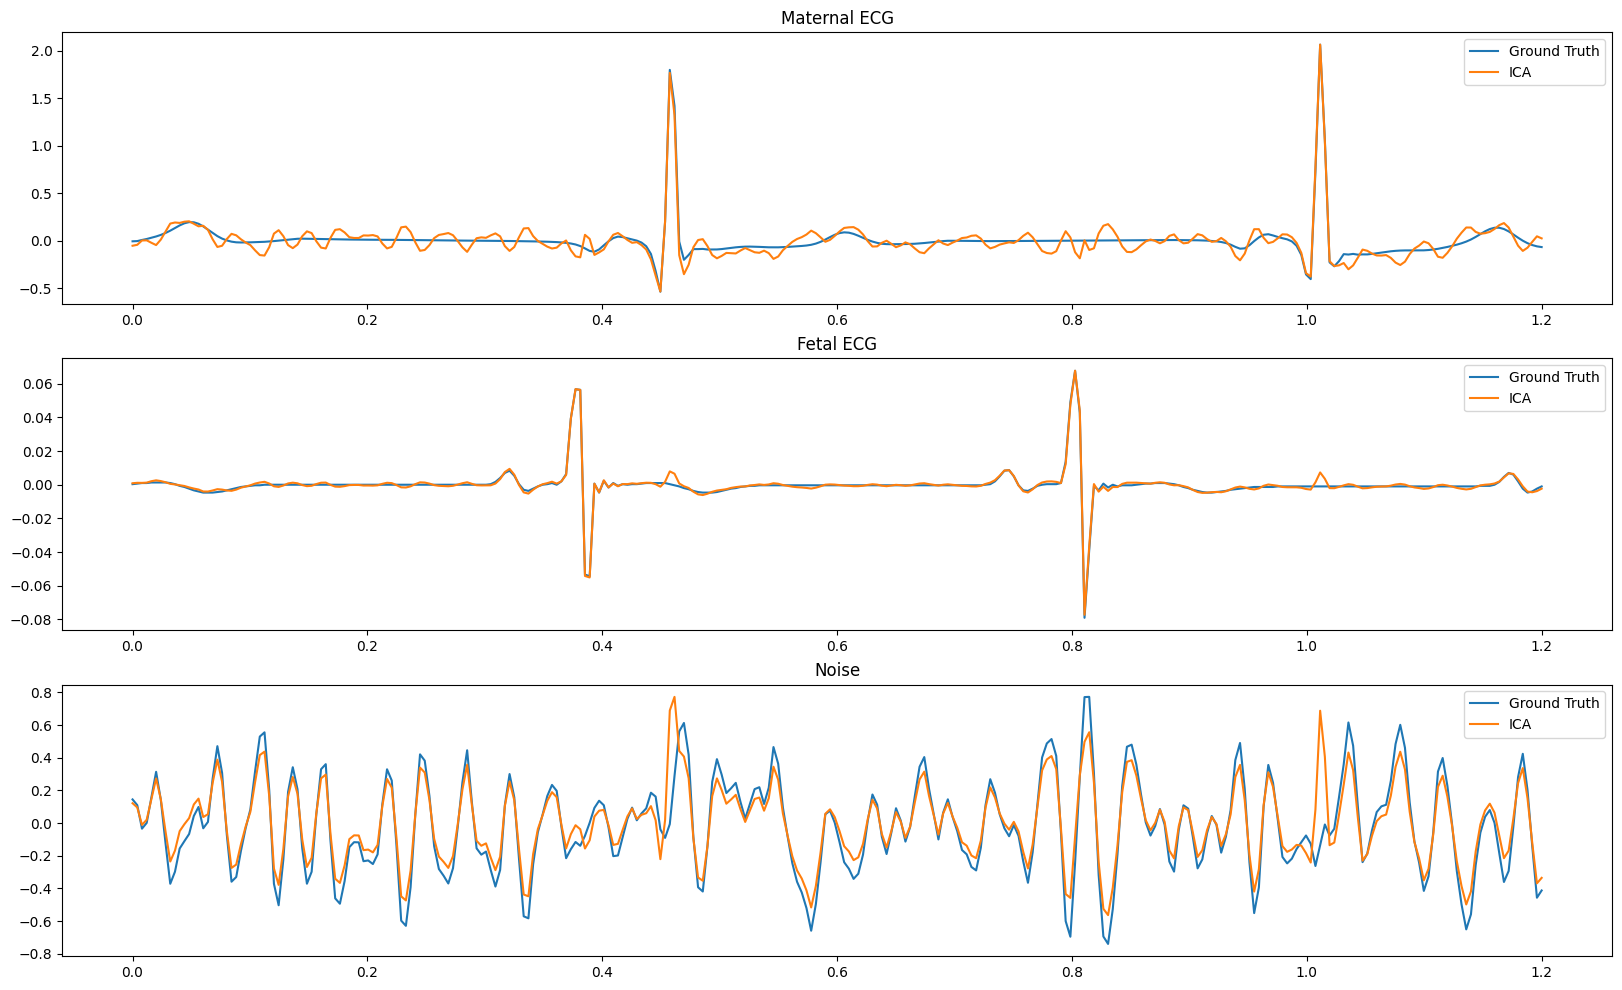

In [10]:
#---------------------Implement your code here:------------------------
S = np.dot(W,X_w)

S_maternal_ecg_norm = S[1,:]*(np.max(maternal_ecg)/np.max(S[1,:]))
S_fetal_ecg_norm = S[0,:]*np.max(fetal_ecg)/np.max(S[0,:])
S_noise_norm = S[2,:]*np.max(noise)/np.max(1*S[2,:])

gt = [maternal_ecg, fetal_ecg, noise]
S_ecgs = [1*S_maternal_ecg_norm, 1*S_fetal_ecg_norm, 1*S_noise_norm]

titles = ['Maternal ECG', 'Fetal ECG', 'Noise']
fig, axs = plt.subplots(3,1,figsize=(20,12))
for i, ax in enumerate(axs.ravel()):
    ax.plot(t, gt[i], label='Ground Truth')
    ax.plot(t, S_ecgs[i], label='ICA')
    ax.legend()
    ax.set_title(titles[i])

#----------------------------------------------------------------------

In [11]:
maternal_mse = np.sum((maternal_ecg - S_maternal_ecg_norm)**2)/maternal_ecg.shape
fetal_mse = np.sum((fetal_ecg - S_fetal_ecg_norm)**2)/fetal_ecg.shape
noise_mse = np.sum((noise - S_noise_norm)**2)/noise.shape

We used trial and error in order to see which of our plots fits best the GT components and also which ones need a flip.
We'll use those mse values for a later comparison.

As usual, `sklearn` has its own method built in. Use `FastICA` as imported in the following cell to perform the same task. Notice carefully for the dimensions of the data $X$ that it expects to operate on. Check [here](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FastICA.html).

In [12]:
from sklearn.decomposition import FastICA
#---------------------Implement your code here:------------------------
ICA = FastICA(random_state=336546, whiten='eigh')
X_transformed = ICA.fit_transform(X.T).T
#----------------------------------------------------------------------

Plot and compare the results to what you did. You should have pretty similar results up to scaling factors.

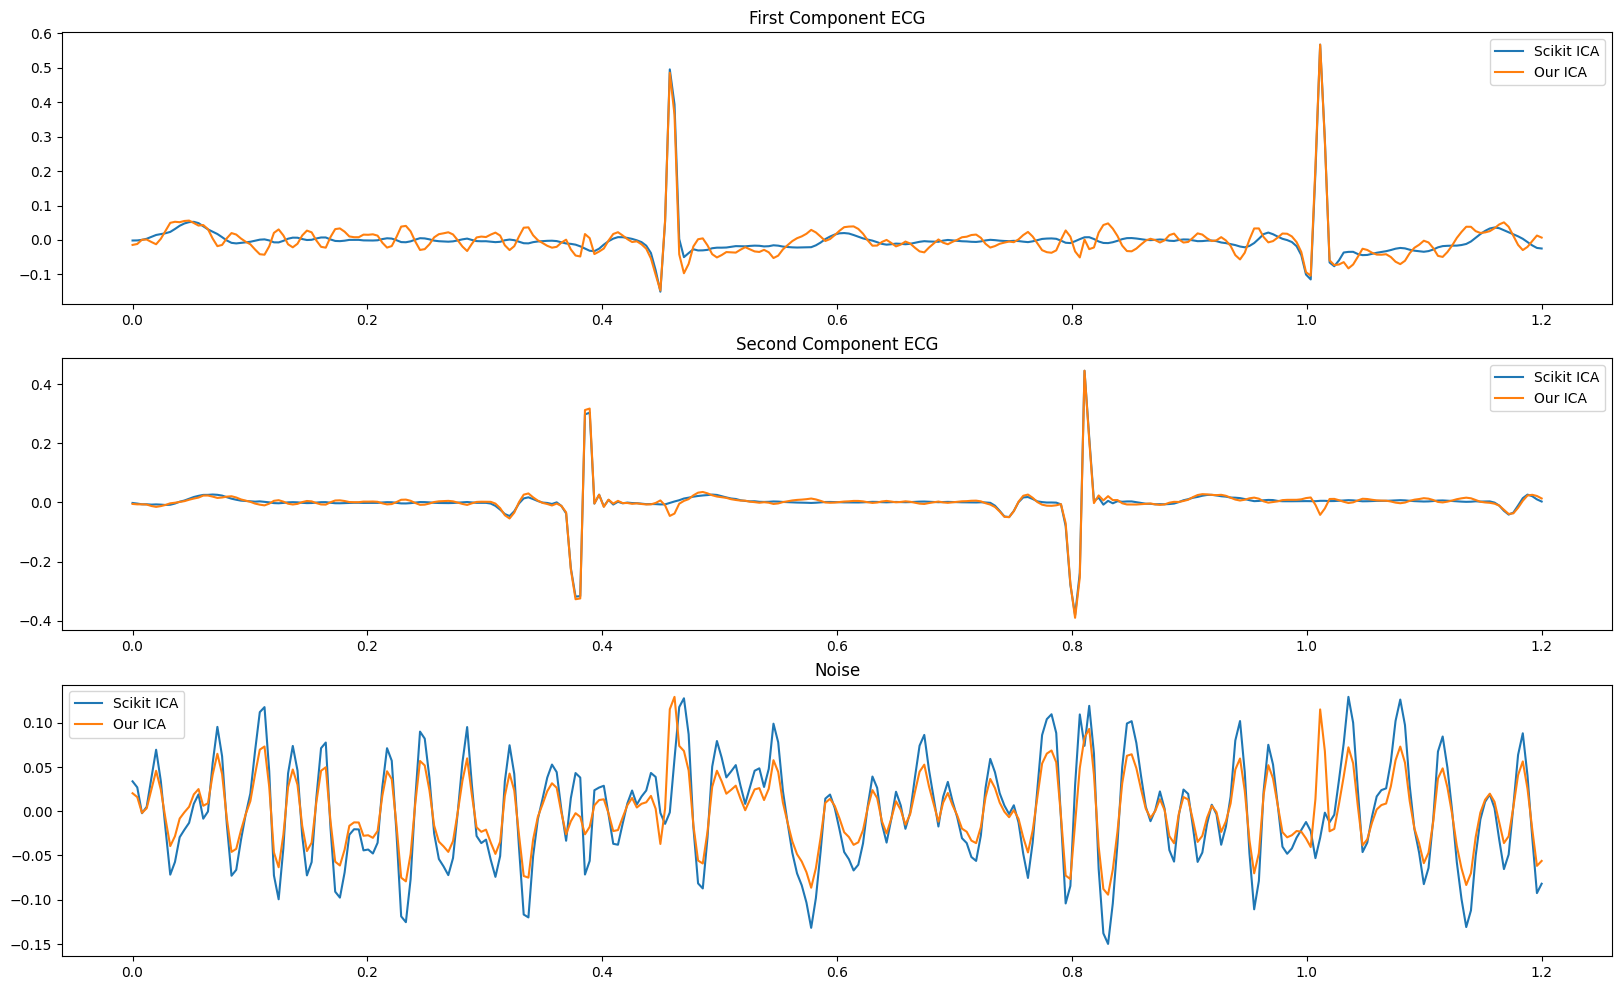

In [13]:
#---------------------Implement your code here:------------------------
sk_ecgs = [X_transformed[2,:], X_transformed[1,:], X_transformed[0,:]]

S_maternal_ecg_norm2 = S[1,:]*(np.max(sk_ecgs[0])/np.max(S[1,:]))
S_fetal_ecg_norm2 = S[0,:]*np.max(sk_ecgs[1])/np.max(-S[0,:])
S_noise_norm2 = S[2,:]*np.max(sk_ecgs[2])/np.max(1*S[2,:])

S_ecgs_1 = [S_maternal_ecg_norm2, -S_fetal_ecg_norm2, S_noise_norm2]
titles = ['First Component ECG', 'Second Component ECG', 'Noise']
fig, axs = plt.subplots(3,1,figsize=(20,12))
for i, ax in enumerate(axs.ravel()):
    ax.plot(t, sk_ecgs[i], label='Scikit ICA')
    ax.plot(t, S_ecgs_1[i], label='Our ICA')
    ax.legend()
    ax.set_title(titles[i])
plt.show()
#----------------------------------------------------------------------

The noise plot from our ICA fits the noise from scikit's ICA, but for the other plots we can't tell which one is the fetal ECG and which is the maternal. Also, our fetal/maternal ecg plots are a bit noisier than scikit's ones, but overall the results are the same.

Now we will take the same measurements but with higer SNR (signal to noise ratio):

In [14]:
X_clean = np.load('mixed_signal12.npy')
X_clean.shape

(3, 300)

We will run again the ICA.

In [15]:
X_w = whitening(X_clean)
np.random.seed(42)
max_iter = 3000
threshold = 1e-10
n_component = X_w.shape[0]
W = np.zeros((3,3))
for p in tqdm(range(n_component)):
    converge = False
    w_p = np.random.randn(n_component)
    iter_count = 0
    while iter_count< max_iter and not converge: 
        w_p_new = update_wp(w_p,X_w,W,p) # your function is called here       
        if np.abs(w_p.dot(w_p_new) - 1) < threshold:
            converge = True
        w_p = w_p_new
        iter_count +=1
    W[p,:] = w_p

  0%|          | 0/3 [00:00<?, ?it/s]

These are the ground true measurements:

In [16]:
GT = np.load('groundtruth12.npy')
GT = GT.T
maternal_ecg = GT[0,:]
fetal_ecg = GT[1,:]
noise = GT[2,:]

Compare the results agian with the given ground true measurements given in the cell above. 

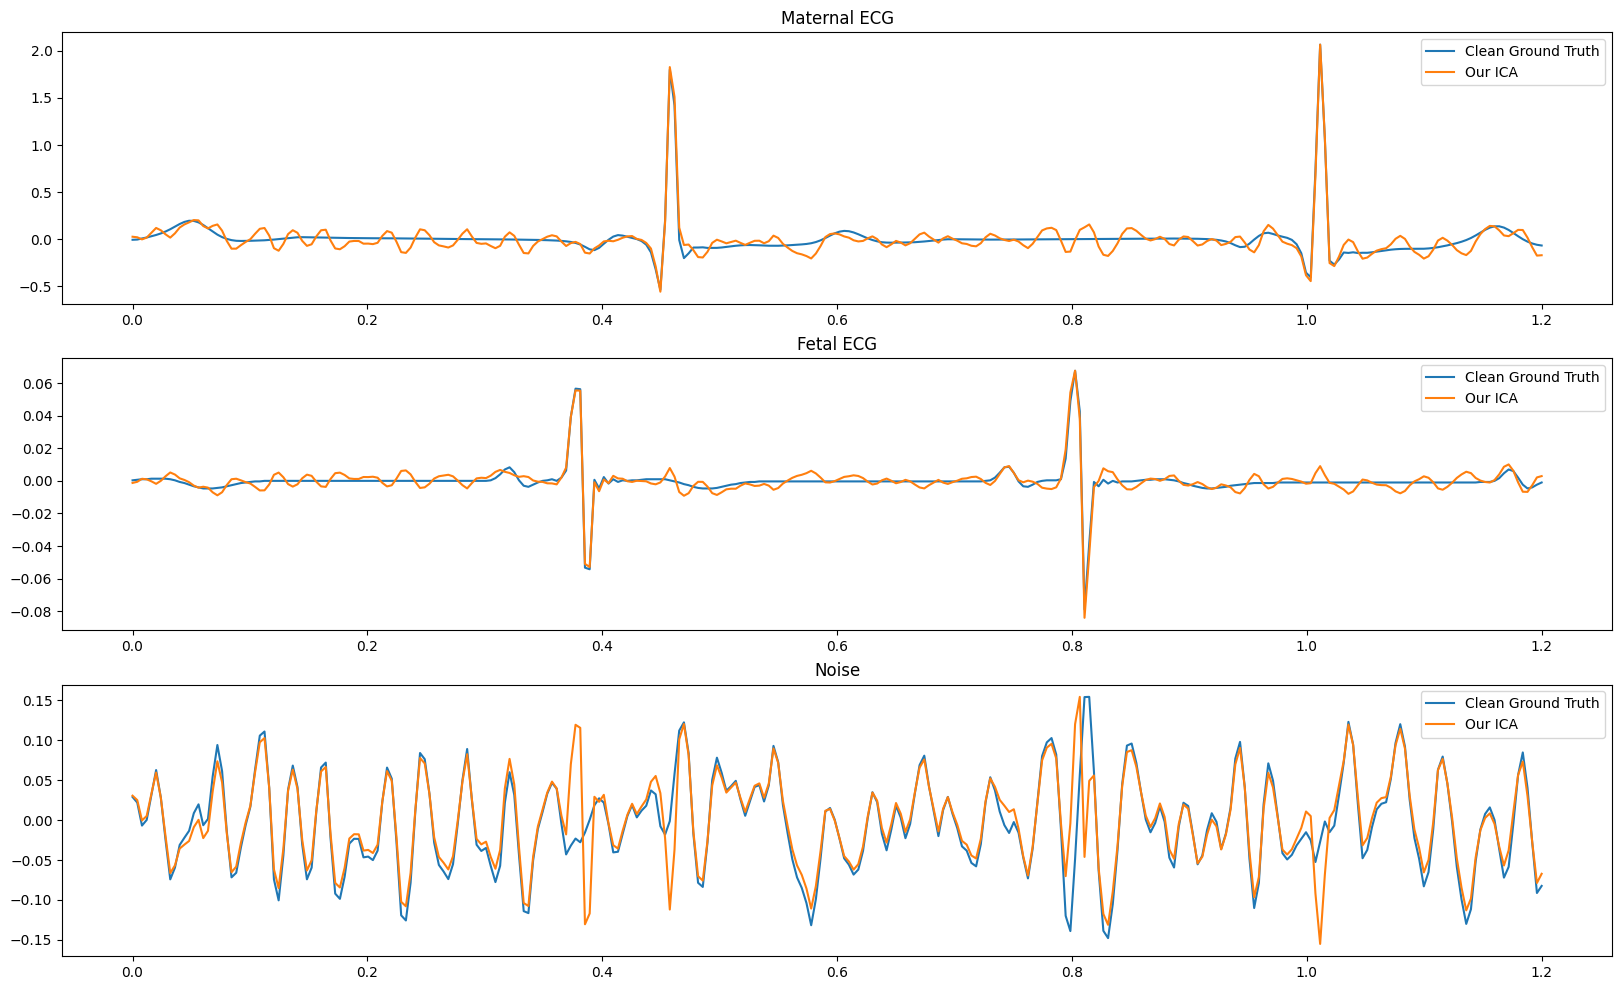

In [17]:
#---------------------Implement your code here:------------------------
S_new = np.dot(W,X_w)

S_maternal_ecg_norm = S_new[0,:]*(np.max(maternal_ecg)/np.max(-1*S_new[0,:]))
S_fetal_ecg_norm = S_new[1,:]*np.max(fetal_ecg)/np.max(-1*S_new[1,:])
S_noise_norm = S_new[2,:]*np.max(noise)/np.max(-1*S_new[2,:])

gt = [maternal_ecg, fetal_ecg, noise]
S_ecgs = [-1*S_maternal_ecg_norm, -1*S_fetal_ecg_norm, -1*S_noise_norm]

titles = ['Maternal ECG', 'Fetal ECG', 'Noise']
fig, axs = plt.subplots(3,1,figsize=(20,12))
for i, ax in enumerate(axs.ravel()):
    ax.plot(t, gt[i], label='Clean Ground Truth')
    ax.plot(t, S_ecgs[i], label='Our ICA')
    ax.legend()
    ax.set_title(titles[i])

#----------------------------------------------------------------------

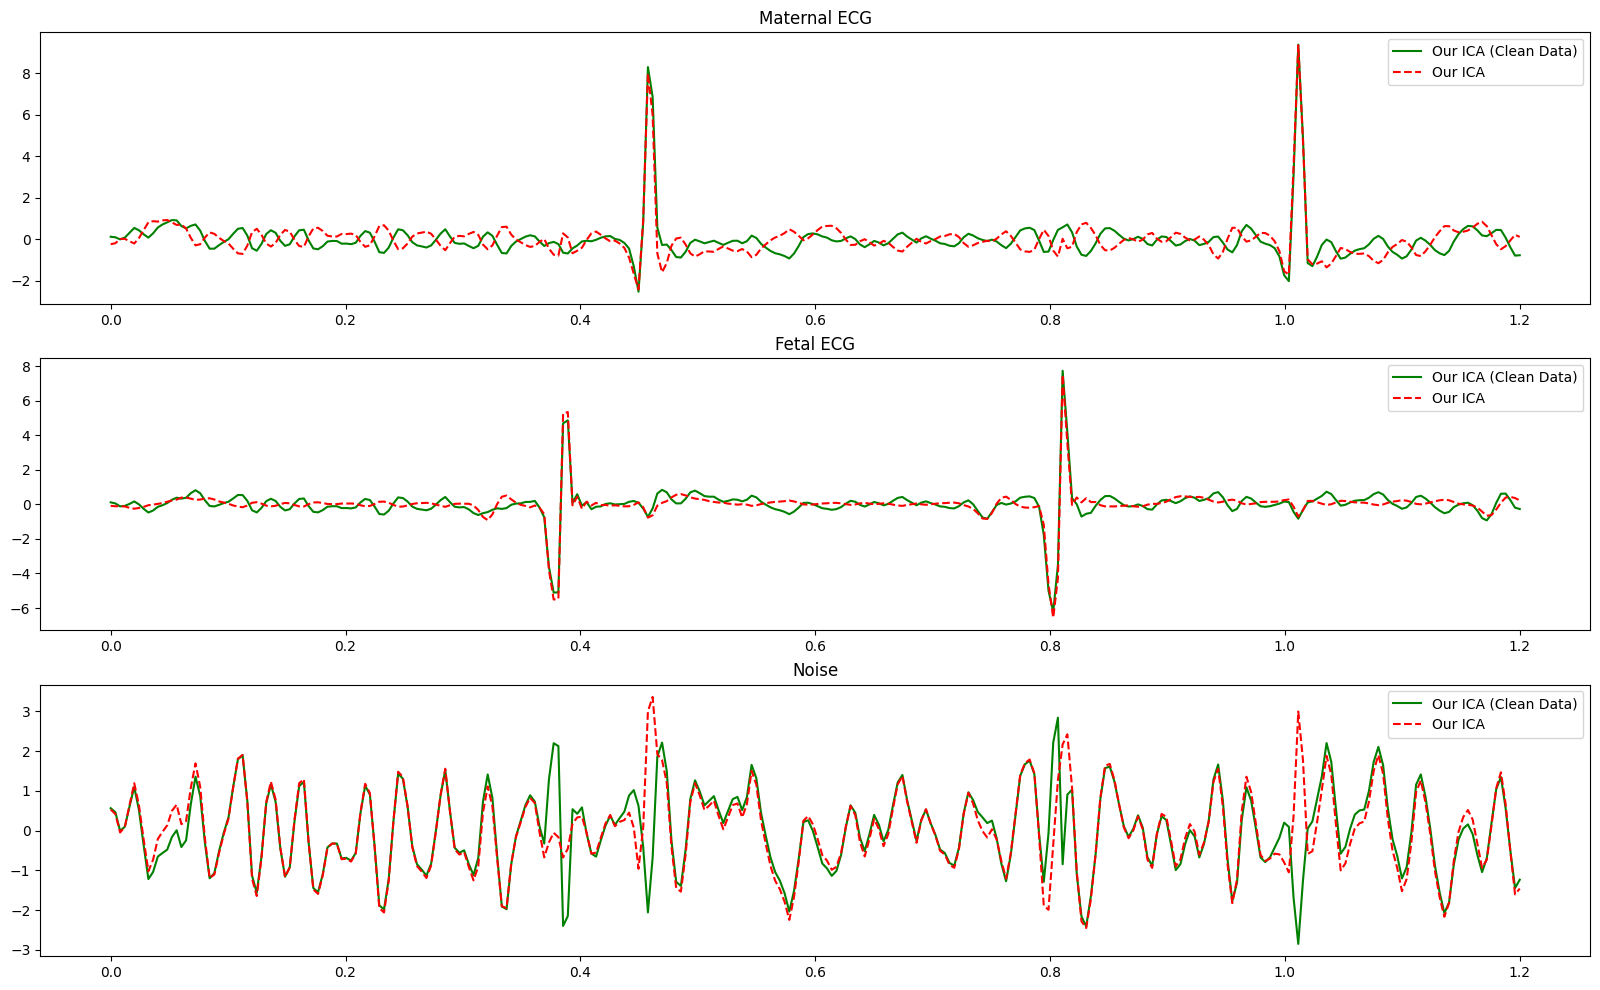

In [18]:
S_ecgs = [S[1,:], -S[0,:], S[2,:]]
S_ecgs_new = [-S_new[0,:], S_new[1,:], -S_new[2,:]]

titles = ['Maternal ECG', 'Fetal ECG', 'Noise']
fig, axs = plt.subplots(3,1,figsize=(20,12))
for i, ax in enumerate(axs.ravel()):
    ax.plot(t, S_ecgs_new[i],color='g', label='Our ICA (Clean Data)')
    ax.plot(t, S_ecgs[i],'--', color='r', label='Our ICA')
    ax.legend()
    ax.set_title(titles[i])

We can see that there are some differences between the ICA reconstructions. In order to emphasize better this difference, we'll use MSE for both signals:

In [19]:
maternal_mse_new = np.sum((maternal_ecg - S_maternal_ecg_norm)**2)/maternal_ecg.shape
fetal_mse_new = np.sum((fetal_ecg - S_fetal_ecg_norm)**2)/fetal_ecg.shape
noise_mse_new = np.sum((noise - S_noise_norm)**2)/noise.shape

print(f'Maternal ECG MSEs: {maternal_mse} for the lower SNR and {maternal_mse_new} for the higher SNR')
print(f'Fetal ECG MSEs: {fetal_mse} for the lower SNR and {fetal_mse_new} for the higher SNR')
print(f'Noise MSEs: {noise_mse} for the lower SNR and {noise_mse_new} for the higher SNR')

Maternal ECG MSEs: [0.00481503] for the lower SNR and [0.17984788] for the higher SNR
Fetal ECG MSEs: [1.37450517e-06] for the lower SNR and [0.00043828] for the higher SNR
Noise MSEs: [0.01176888] for the lower SNR and [0.01157831] for the higher SNR


Did you expect better recontruction with higher SNR. If it did not happen, what could possibly explain it?

## Answer:
Higher SNR can lead to a better separation of the sources, but not necessarily a better reconstruction of the original data. That's because the goal of ICA is to separate the mixed signals in an unsupervised manner, meaning it's not aiming to find separated independent signals that are close to the original data, only that they are separate. In general, the ICA will perform better in terms of reconstructions if the data truly meets the basic statistical assumptions that we take when using ICA.


GOOD LUCK!